# Fitting for non linearity coefficients in a simulated dark (sci) frame


In [1]:
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def slope(x,a):
    return  a*x

dark = pyfits.getdata('sc456_crRejectSF.fits')

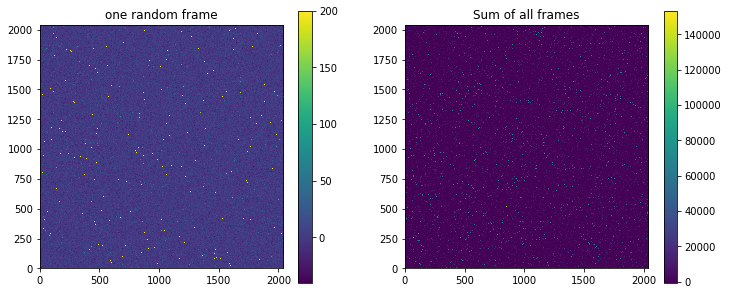

In [2]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('one random frame')
plt.imshow(dark[:,:,np.random.randint(200)],vmax = 200,origin = 'lower')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Sum of all frames')
plt.imshow(np.sum(dark[:,:,:200],axis=2),origin = 'lower')
plt.colorbar()

### Averaging all the pixels to beat down the noise, the non linearity in the dark can be well seen:

In [9]:
dark[dark>40]= np.nan ## removing pixels with high flux, Cosmic ray?

dark_mean = np.nanmean(dark.reshape([-1,200]) ,axis=0) 
dark_median = np.nanmedian(dark.reshape([-1,200]),axis=0)

/Users/shemmati/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


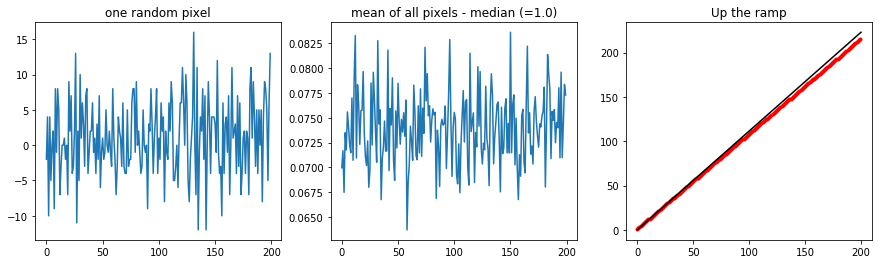

In [12]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title('one random pixel')
plt.plot(range(200),dark[np.random.randint(2040),np.random.randint(2040),:])

plt.subplot(1,3,2)
plt.title('mean of all pixels - median (=1.0)')
plt.plot(range(200),dark_mean-dark_median)

plt.subplot(1,3,3)
plt.title('Up the ramp')
plt.plot(range(200),np.cumsum(dark_mean),'r.')

## fitting a line to the fitst 40 frames to see the non_linearity towards later frames
popt, pcov = curve_fit(slope, range(40), np.cumsum(dark_mean)[0:40])
plt.plot([0,200],[0,popt*200],'k-')


In [13]:
def non_linearity(x,a1,a2):
    return a1*x+a2*x**2

coefs, pcov2 = curve_fit(non_linearity, np.cumsum(dark_mean),range(200)*popt[0])
print('a1='+str(coefs[0])+', a2='+str(coefs[1]))

a1=1.0173519839415999, a2=7.972230924426823e-05


### Instead of averaging all the pixels, doing so for a smaller subset, let say 1/30:

In [14]:
d = dark.reshape([-1,200])
dark_mean = np.nanmean(d[::30,:] ,axis=0) 
dark_median = np.nanmedian(d[::30,:],axis=0)

In [15]:
print(np.shape(d))
print(np.shape(d[::3,:]))

(4161600, 200)
(1387200, 200)


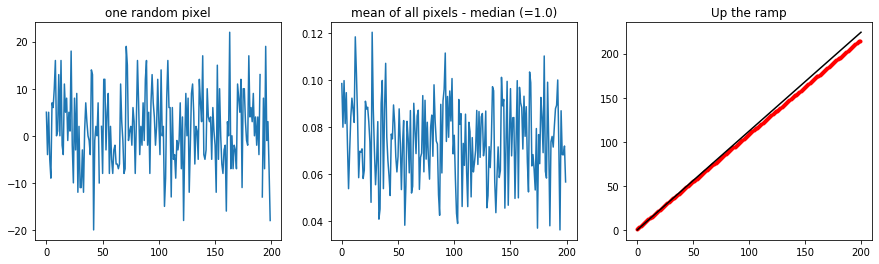

In [16]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title('one random pixel')
plt.plot(range(200),dark[np.random.randint(2040),np.random.randint(2040),:])

plt.subplot(1,3,2)
plt.title('mean of all pixels - median (=1.0)')
plt.plot(range(200),dark_mean-dark_median)

plt.subplot(1,3,3)
plt.title('Up the ramp')
plt.plot(range(200),np.cumsum(dark_mean),'r.')

## fitting a line to the fitst 40 frames to see the non_linearity towards later frames
popt2, pcov2 = curve_fit(slope, range(40), np.cumsum(dark_mean)[0:40])
plt.plot([0,200],[0,popt2*200],'k-')


## What I got from the MDB as coefficients:

In [17]:
coef = pyfits.getdata('EUC_NISP_H2RG-NONLINEARITY-CORRECTION-COEFFICIENTS-PHOTOH_2017-04-21T201300.00Z_01.01.fits')

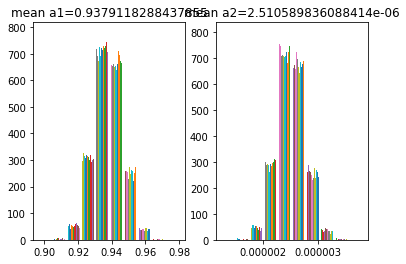

In [18]:
plt.subplot(1,2,1)
plt.title('mean a1='+str(np.mean(coef[3,:,:])))
ah = plt.hist(coef[3,:,:])

plt.subplot(1,2,2)
plt.title('mean a2='+str(np.mean(coef[4,:,:])))
ah = plt.hist(coef[4,:,:])


## Misc

In [ ]:
ng, nf, nd = 4,16,4 # For H photometric

f_low = 0 
f_up = (59000 - 3000) * ng*(nf+nd) / ((ng-1)*nd + ng*nf) 


def kubik_flux(pixel, ng = 4, nf = 16, nd = 4):
    '''to measure the flux using kubik 2016 new estimator'''
    fe = 1.32 # e/ADU 
    sigma_r = 10 # e
    
    alpha = (1.0-nf**2)/(3.0*nf*(nf+nd))
    beta = (2.0*sigma_r**2.0 * fe)/(nf*(1.0+alpha))
    
    GK,DG = np.zeros(ng),np.zeros(ng-1)
    GK[0] = np.sum(pixel[0:nf])/(nf*1.0)
    pixel[pixel<f_low] = 0.0
    pixel[pixel>30] = 0.0
    for j in range(1,ng):
        GK[j] = np.sum(pixel[j*(nf+nd):(j+1)*nf+j*nd])/nf 
        DG[j-1] = GK[j] - GK[j-1] 
        
    g = ((1.0+alpha)/(2*fe))*(np.sqrt(1.0+((4.0*fe**2* np.sum((DG+beta)**2.0))/((ng-1)*(1.0+alpha)**2))) -1.0) - beta
    return GK,g, pixel



In [ ]:
def DPU_flux(pixel, ng =4, nf = 16, nd = 4):
    sigma_r = 10 #e
    
    #bprim = np.sqrt((np.sum((Si-Si1 + 2.0*(sigma_r)**2.0/nf)**2.0))/(ng-1))
    
    gamma = 2.*(sigma_r**2)/nf
    alpha = (1.-nf**2.)/(3.0*nf*(nf+nd))
    beta = gamma/(alpha+1.0)
    
    GK = np.zeros(ng)
    GK [0] = 0
    GK[1] = 
    for j in range(2,ng): 
        a = np.sqrt(np.sum((Si-Si1+beta)**2.0)/(ng-1))
    
    x2 = (2.0*(ng-1)*a - 2.*(Sg-S1) - 2.*(ng-1)*beta)/(1+alpha)
    
    return a,x2